

# Probabilistic Principal Component Analysis (PPCA) on Digits Dataset

This code implements PPCA by two methods:
1. ML solution using spectral decomposition.
2. EM algorithm for PPCA.

Note: The data is loaded from the UCI "Optical Recognition of Handwritten Digits"
      dataset (file: opdigits.tes). This dataset contains 1797 samples, each with
      64 features (the last column is the digit label), which is equivalent to
      sklearn.datasets.load_digits.




## Data Loading
Load the digits dataset.

In [124]:

# -----------------------------
# 1. Data Loading
# -----------------------------
# Download and load the digits dataset from UCI.

digits_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"
if (!file.exists("optdigits.tes")) {
  download.file(digits_url, destfile = "optdigits.tes")
}


In [125]:

# Read the data (comma-separated): first 64 columns are features, the 65th column is label.
digits_data <- read.table("optdigits.tes", sep = ",", header = FALSE)
X <- as.matrix(digits_data[, 1:64])
y <- digits_data[, 65]

cat("X shape:", dim(X), "\n")           # Should be (1797, 64)
cat("Unique labels:", sort(unique(y)), "\n")  # Expected: 0-9


X shape: 1797 64 
Unique labels: 0 1 2 3 4 5 6 7 8 9 


In [126]:


Xtrain <- X
ytrain <- y


pdf 
  2

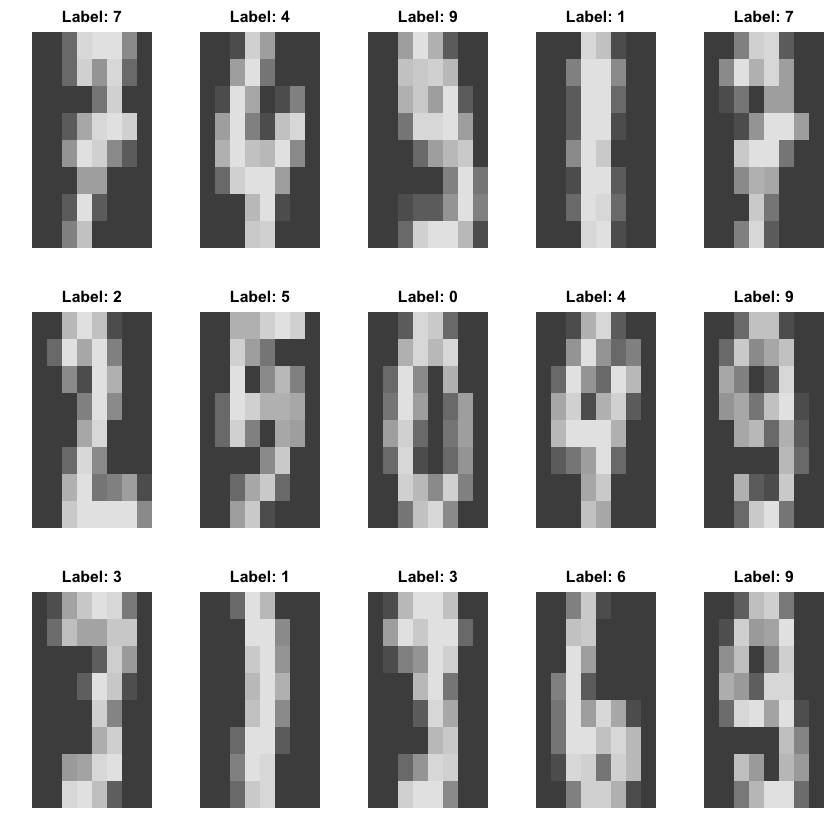

In [127]:
# Function to visualize random digit samples
visualize_digits <- function(X, y, n_samples=15, random_state=42) {
  set.seed(random_state)
  indices <- sample(1:nrow(X), n_samples, replace = FALSE)
  n_cols <- 5
  n_rows <- ceiling(n_samples / n_cols)
  par(mfrow=c(n_rows, n_cols), mar=c(2, 2, 2, 1))
  
  for (i in 1:n_samples) {
    
    digit_image <- t(matrix(X[indices[i], ], nrow=8, ncol=8, byrow=TRUE))
    
    image(digit_image[, ncol(digit_image):1], 
          col=gray.colors(256), 
          axes=FALSE)
    title(main=paste("Label:", y[indices[i]]))
  }
}

visualize_digits(X, y, n_samples=15)
# save the plot to a pdf
pdf("digits_visualization.pdf")
visualize_digits(X, y, n_samples=15)
dev.off()


## ML PPCA
Compute ML estimates using spectral decomposition and project the data to a lower-dimensional space.

Formulas:
- Mean:  $\mu = \bar{x}$
- Noise variance:  $\sigma^2_{ML} = \frac{1}{D-M} \sum_{m=M+1}^{D} \lambda_m$
- Loading matrix:  $W_{ML} = U_M \left(L_M - \sigma^2_{ML} I\right)^{1/2}$
- Posterior mean:  $E[z] = (W^T W+\sigma^2 I)^{-1} W^T (x-\mu)$
- Where:
  *  ${\bf U}_M$ is an $D \times M$ matrix whose columns are given by the $M$ eigenvectors with corresponding largest $M$ eigenvalues
  * ${\bf L}_M$ is a diagonal $M\times M$ matrix of the corresponding eigenvectors
  * ${\bf R}$ is an arbitrary orthogonal $M\times M$ matrix( we take ${\bf R}={\bf I}$)


In [128]:

M <- 2  # Latent dimension
mu <- colMeans(Xtrain)
X_centered <- scale(Xtrain, center = TRUE, scale = FALSE)  # Center the data


In [129]:

# Compute the covariance matrix (D x D)
S <- cov(X_centered)


In [130]:

# Eigen-decomposition (eigen() returns eigenvalues in descending order by default)
eig <- eigen(S)
eigenvalues  <- eig$values
eigenvectors <- eig$vectors
D <- ncol(Xtrain)


In [131]:

# Compute σ²_ML using the eigenvalues not used for the latent space.
sigma2_ml <- sum(eigenvalues[(M + 1):D]) / (D - M)
cat("ML sigma2:", sigma2_ml, "\n")


ML sigma2: 13.86166 


In [132]:

# Compute W_ML = U_M * diag(sqrt(λ_m - σ²_ML))
W_ml <- eigenvectors[, 1:M] %*% diag(sqrt(eigenvalues[1:M] - sigma2_ml), nrow = M)


In [133]:

# Posterior projection: E[z] = (W^T W + σ² I)^{-1} W^T (X - μ)^T
M_mat <- t(W_ml) %*% W_ml + sigma2_ml * diag(M)
Ez_ml <- solve(M_mat) %*% (t(W_ml) %*% t(X_centered))  # Result is (M x N)


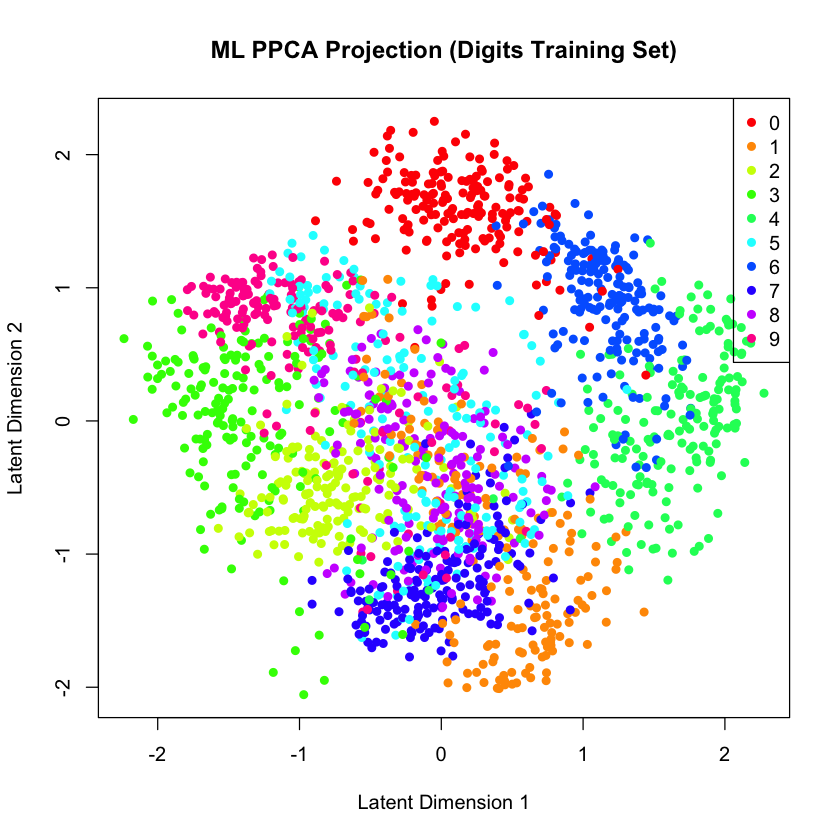

In [134]:

# Plot the ML PPCA projection (different colors for each digit)
plot(Ez_ml[1, ], Ez_ml[2, ], col = rainbow(10)[ytrain + 1], pch = 16,
     xlab = "Latent Dimension 1", ylab = "Latent Dimension 2",
     main = "ML PPCA Projection (Digits Training Set)")
legend("topright", legend = 0:9, col = rainbow(10), pch = 16)



## EM Algorithm Implementation for PPCA

The EM algorithm for PPCA works as follows:
- **E-step:** For each sample $x_n$, compute:
  $$
  E[z_n] = (W^T W+\sigma^2 I)^{-1}W^T(x_n-\bar{x})
  $$
  $$
  E[z_n z_n^T] = E[z_n]E[z_n]^T + \sigma^2 (W^T W+\sigma^2 I)^{-1}
  $$
- **M-step:** Update parameters:
  $$
  W_{\text{new}} = \left(\sum_{n}(x_n-\bar{x})\,E[z_n]^T\right)\left(\sum_{n}E[z_n z_n^T]\right)^{-1}
  $$
  $$
  \sigma^2_{\text{new}} = \frac{1}{ND}\sum_{n}\left(\|x_n-\bar{x}\|^2 - 2\,E[z_n]^T\,W^T(x_n-\bar{x}) + \operatorname{Tr}(W^TW\,E[z_n z_n^T])\right)
  $$


In [135]:

ProbabilisticPCA <- function(X, M, W_init = NULL, sigma2_init = NULL, seed = NULL) {
  if (!is.null(seed)) set.seed(seed)
  N <- nrow(X)
  D <- ncol(X)
  # Center the data
  Xbar <- scale(X, center = TRUE, scale = FALSE)
  Xnorm2 <- sum(Xbar^2)

  # Initialize W
  if (is.null(W_init)) {
    W <- matrix(rnorm(D * M), nrow = D, ncol = M)
  } else {
    W <- W_init
  }
  # Initialize σ²
  if (is.null(sigma2_init)) {
    sigma2 <- runif(1)
  } else {
    sigma2 <- sigma2_init
  }

  # Create a list to store parameters and functions
  ppca <- list()
  ppca$N <- N
  ppca$D <- D
  ppca$M <- M
  ppca$Xbar <- Xbar
  ppca$Xnorm2 <- Xnorm2
  ppca$W <- W
  ppca$sigma2 <- sigma2
  ppca$seed <- seed

  # E-step: Compute posterior mean E[z_n] and second moment E[z_n z_n^T] for all samples.
  ppca$compute_expectations <- function() {
    Mz <- t(ppca$W) %*% ppca$W + ppca$sigma2 * diag(ppca$M)
    i_Mz <- solve(Mz)
    # E[z] = M^{-1} W^T (X - μ)^T, resulting in a (M x N) matrix.
    E_zn <- i_Mz %*% (t(ppca$W) %*% t(ppca$Xbar))
    # For each sample, compute E[z_n z_n^T] = E[z_n]E[z_n]^T + σ² * M^{-1}
    E_znzn <- array(0, dim = c(ppca$M, ppca$M, ppca$N))
    for (n in 1:ppca$N) {
      ez <- E_zn[, n, drop = FALSE]
      E_znzn[,,n] <- ez %*% t(ez) + ppca$sigma2 * i_Mz
    }
    list(E_zn = E_zn, E_znzn = E_znzn)
  }

  # Compute the complete-data log-likelihood Q
  ppca$data_log_likelihood <- function(E_zn, E_znzn) {
    term1 <- - ppca$N * ppca$M * log(2*pi) / 2
    term2 <- - sum(sapply(1:ppca$N, function(n) { sum(diag(E_znzn[,,n])) }))
    term3 <- - ppca$D * log(2*pi*ppca$sigma2) / 2
    term4 <- - ppca$Xnorm2 / (2 * ppca$sigma2)
    term5 <- 0
    term6 <- 0
    # term5: sum_{n=1}^N E[z_n]^T W^T (x_n - μ)
    for (n in 1:ppca$N) {
      x_n <- ppca$Xbar[n, ]
      ez <- E_zn[, n, drop = FALSE]
      term5 <- term5 + sum((t(ppca$W) %*% x_n) * ez)
      term6 <- term6 + sum(diag(t(ppca$W) %*% ppca$W %*% E_znzn[,,n]))
    }
    Q <- term1 + term2 + term3 + term4 + term5 / ppca$sigma2 - term6 / ppca$sigma2
    Q
  }

  # M-step: Update W.
  ppca$update_W <- function(E_zn, E_znzn) {
    # T1 = sum_{n=1}^N (x_n - μ) E[z_n]^T; note Xbar is (N x D), so T1 becomes (D x M)
    T1 <- t(ppca$Xbar) %*% t(E_zn)
    # T2 = sum_{n=1}^N E[z_n z_n^T]
    T2 <- apply(E_znzn, c(1,2), sum)
    W_new <- T1 %*% solve(T2)
    W_new
  }

  # M-step: Update σ².
  ppca$update_sigma2 <- function(E_zn, E_znzn) {
    total <- 0
    for (n in 1:ppca$N) {
      x_n <- ppca$Xbar[n, ]
      ez <- E_zn[, n]
      Ezz <- E_znzn[,,n]
      total <- total + sum(x_n^2) - 2 * as.numeric(ez %*% (t(ppca$W) %*% x_n)) +
        sum(diag(t(ppca$W) %*% ppca$W %*% Ezz))
    }
    sigma2_new <- total / (ppca$N * ppca$D)
    sigma2_new
  }

  # Projection: Compute the expected latent representation for X.
  ppca$project <- function() {
    Mz <- t(ppca$W) %*% ppca$W + ppca$sigma2 * diag(ppca$M)
    Xproj <- solve(Mz) %*% (t(ppca$W) %*% t(ppca$Xbar))
    Xproj  # (M, N)
  }

  # One EM step: perform E-step followed by M-step and return the current Q value.
  ppca$EM_step <- function() {
    exp_out <- ppca$compute_expectations()
    E_zn <- exp_out$E_zn
    E_znzn <- exp_out$E_znzn
    # M-step updates: first update σ², then update W.
    sigma2_new <- ppca$update_sigma2(E_zn, E_znzn)
    W_new <- ppca$update_W(E_zn, E_znzn)
    ppca$sigma2 <<- sigma2_new
    ppca$W <<- W_new
    Q <- - ppca$data_log_likelihood(E_zn, E_znzn)
    Q
  }

  return(ppca)
}



## EM Algorithm Iterations and Results
Run multiple EM iterations, record the Q values and projection results.
Q is defined as the complete data log-likelihood. If Q increases over iterations, the algorithm converges.

In [136]:

M_em <- 2  # latent dimension
ppca <- ProbabilisticPCA(X, M_em, sigma2_init = 10, seed = 2718)

n_iter <- 40
Qhist <- c(ppca$data_log_likelihood(ppca$compute_expectations()$E_zn,
                                      ppca$compute_expectations()$E_znzn))
proj_list <- list(ppca$project())
for (i in 1:n_iter) {
  Q <- ppca$EM_step()
  Qhist <- c(Qhist, Q)
  proj_list[[length(proj_list) + 1]] <- ppca$project()
  # Stop early if convergence is achieved
  if (i > 1 && abs(Qhist[length(Qhist)] - Qhist[length(Qhist)-1]) < 1e-3)
    break
}


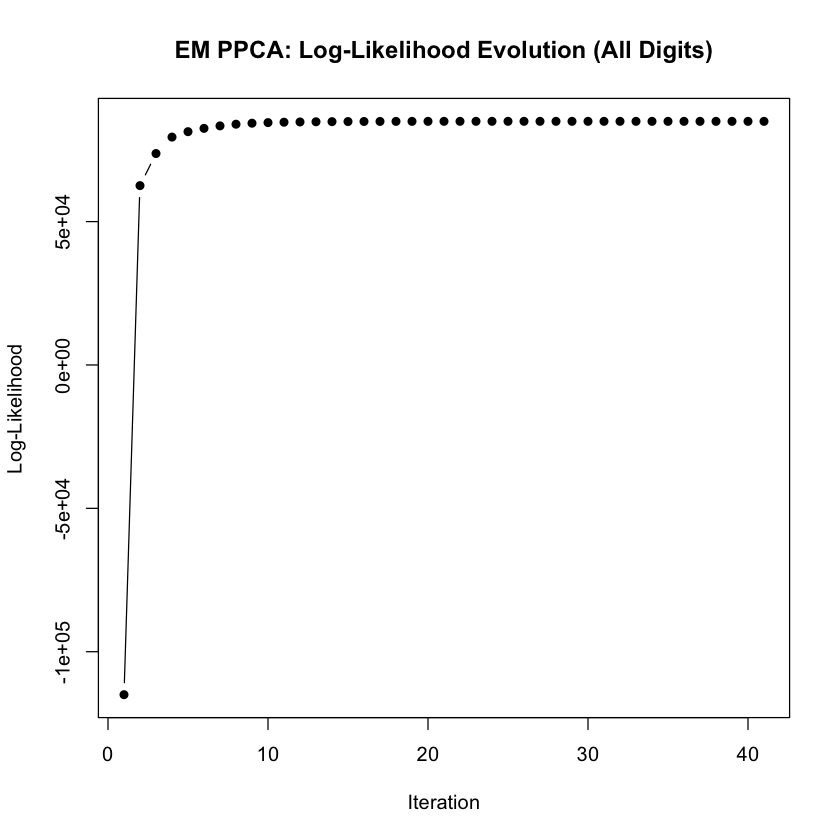

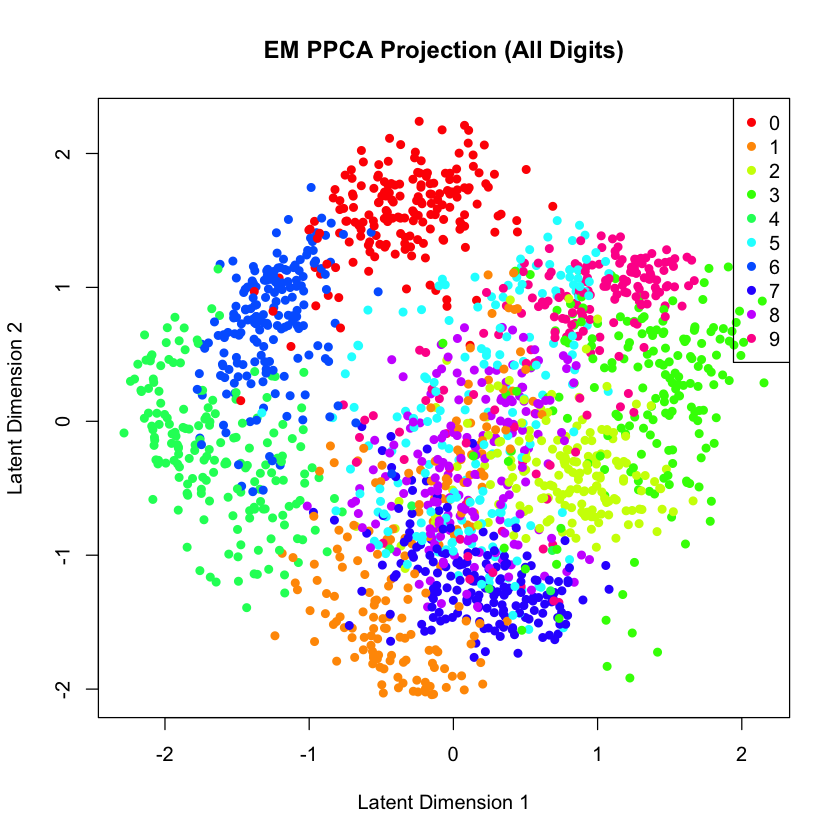

In [137]:

# Plot the evolution of the log-likelihood Q
plot(Qhist, type = "b", pch = 16, xlab = "Iteration", ylab = "Log-Likelihood",
     main = "EM PPCA: Log-Likelihood Evolution (All Digits)")

# Plot the final EM PPCA projection (using all data labels)
proj_em <- ppca$project()
plot(proj_em[1, ], proj_em[2, ], col = rainbow(10)[y + 1], pch = 16,
     xlab = "Latent Dimension 1", ylab = "Latent Dimension 2",
     main = "EM PPCA Projection (All Digits)")
legend("topright", legend = 0:9, col = rainbow(10), pch = 16)

## Task4

The following code show example how to using standard PCA extract the latent embeddings and project the latent embeddings using t-SNE.

In [ ]:
# Check if the Rtsne package is installed
if (!requireNamespace("Rtsne", quietly = TRUE)) {
  # Install the Rtsne package if it's not already installed
  install.packages("Rtsne")
}

 [1] "Variance explained by PCA components:  28.5093648236993"
 [2] "Variance explained by PCA components:  54.4963526726898"
 [3] "Variance explained by PCA components:  63.7292500006396"
 [4] "Variance explained by PCA components:  73.8226768845953"
 [5] "Variance explained by PCA components:  80.2895776104032"
 [6] "Variance explained by PCA components:  83.5305336403744"
 [7] "Variance explained by PCA components:  86.2588384427105"
 [8] "Variance explained by PCA components:  89.4303116598526"
 [9] "Variance explained by PCA components:  95.9085404245717"
[10] "Variance explained by PCA components:  98.8202733661143"


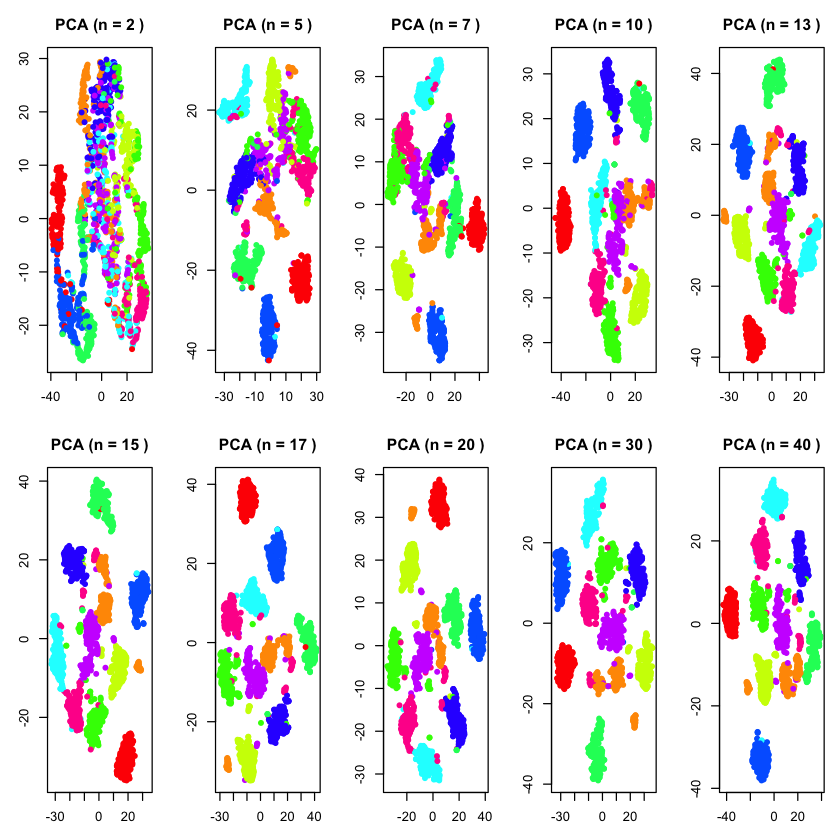

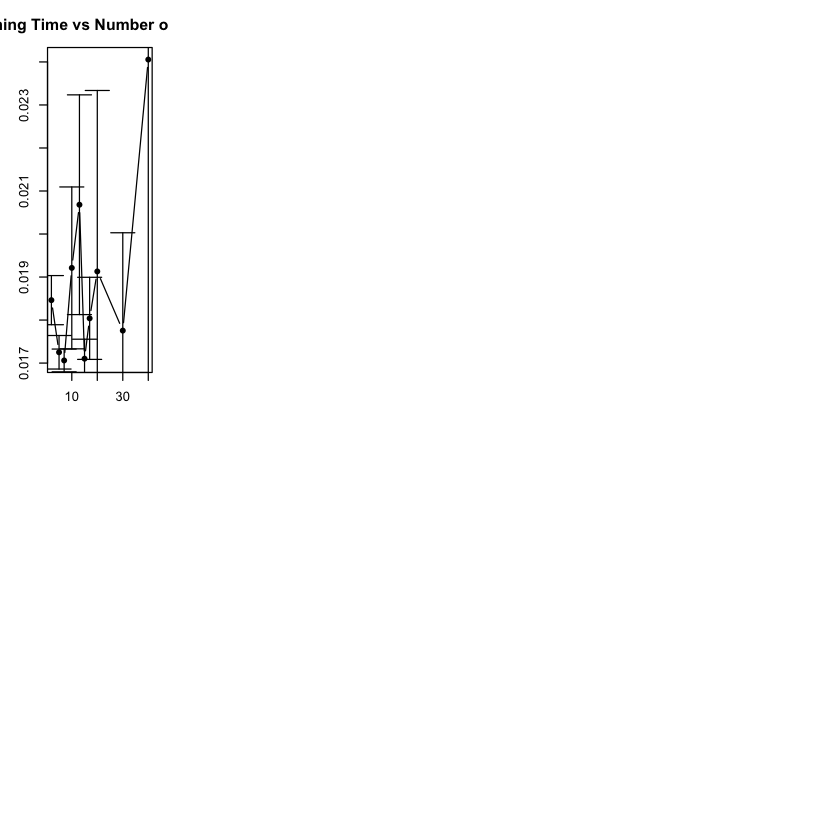

In [138]:
# Load required libraries
library(MASS)       # for SVD decomposition
library(Rtsne)      # for t-SNE
library(ggplot2)    # for plotting

# Function to run PCA once
run_pca_once <- function(X, n_comp) {
  start_time <- Sys.time()
  pca <- prcomp(X, center = TRUE, scale. = FALSE)
  Z <- pca$x[, 1:n_comp]
  end_time <- Sys.time()
  time_taken <- as.numeric(difftime(end_time, start_time, units = "secs"))
  return(list(time_taken = time_taken, pca = pca, Z = Z))
}

# Compare PCA results and visualize projections using t-SNE for different component numbers
compare_svd_pca_components <- function(X, y, components_list = c(2, 5, 10, 20), n_runs = 3) {
  n_plots <- length(components_list)
  n_cols <- 5
  n_rows <- ceiling(n_plots / n_cols)
  
  # Set up plotting grid
  par(mfrow = c(n_rows, n_cols), mar = c(3, 3, 3, 1))
  
  running_times <- numeric(length(components_list))
  running_times_std <- numeric(length(components_list))
  var_explaineds <- numeric(length(components_list))
  
  for (idx in 1:length(components_list)) {
    n_comp <- components_list[idx]
    
    # Run PCA multiple times
    times <- numeric(n_runs)
    for (run in 1:n_runs) {
      result <- run_pca_once(X, n_comp)
      times[run] <- result$time_taken
    }
    
    # Calculate mean and standard deviation of running times
    mean_time <- mean(times)
    std_time <- sd(times)
    running_times[idx] <- mean_time
    running_times_std[idx] <- std_time
    
    # Visualize using t-SNE
    pca_result <- run_pca_once(X, n_comp)
    Z_2d <- Rtsne(pca_result$Z)$Y  # t-SNE transformation
    
    # Plot t-SNE visualization
    plot(Z_2d, col = rainbow(10)[y + 1], pch = 16, main = paste("PCA (n =", n_comp, ")"), xlab = "t-SNE 1", ylab = "t-SNE 2")
    var_explaineds[idx] <- sum(pca_result$pca$sdev[1:n_comp]^2) / sum(pca_result$pca$sdev^2) * 100
  }
  
  # Plot running times with error bars
  plot(components_list, running_times, type = "b", pch = 16, xlab = "Number of Components", ylab = "Time (s)", 
       main = "PCA Running Time vs Number of Components")
  arrows(components_list, running_times - running_times_std, components_list, running_times + running_times_std, angle = 90, code = 3, length = 0.1)
  
  # Display variance explained for each component number
  print(paste("Variance explained by PCA components: ", var_explaineds))
}

# Use previously loaded X and y data
components_to_try <- c(2, 5, 7, 10, 13, 15, 17, 20, 30, 40)
compare_svd_pca_components(X, y, components_list = components_to_try)

### ML PPCA

In [139]:
# Function to run ML-PPCA once and record time
run_mlppca_once <- function(X, n_comp) {
  start_time <- Sys.time()
  
  # Center the data
  mu <- colMeans(X)
  X_centered <- scale(X, center = TRUE, scale = FALSE)
  
  # Compute covariance matrix
  S <- cov(X_centered)
  
  # Eigen-decomposition
  eig <- eigen(S)
  eigenvalues <- eig$values
  eigenvectors <- eig$vectors
  D <- ncol(X)
  
  # Compute σ²_ML using the eigenvalues not used for the latent space
  sigma2_ml <- sum(eigenvalues[(n_comp + 1):D]) / (D - n_comp)
  
  # Compute W_ML = U_M * diag(sqrt(λ_m - σ²_ML))
  W_ml <- eigenvectors[, 1:n_comp] %*% 
          diag(sqrt(eigenvalues[1:n_comp] - sigma2_ml), nrow = n_comp)
  
  # Posterior projection: E[z] = (W^T W + σ² I)^{-1} W^T (X - μ)^T
  M_mat <- t(W_ml) %*% W_ml + sigma2_ml * diag(n_comp)
  Z <- t(solve(M_mat) %*% (t(W_ml) %*% t(X_centered)))  # Result is (N x M)
  
  end_time <- Sys.time()
  time_taken <- as.numeric(difftime(end_time, start_time, units = "secs"))
  
  return(list(
    time_taken = time_taken,
    Z = Z,
    W = W_ml,
    sigma2 = sigma2_ml,
    mu = mu
  ))
}



In [140]:
# Compare ML-PPCA results with different components
compare_mlpca_components <- function(X, y, components_list = c(2, 5, 10, 20), n_runs = 3) {
  n_plots <- length(components_list)
  n_cols <- 5
  n_rows <- ceiling(n_plots / n_cols)
  
  # Set up plotting grid
  par(mfrow = c(n_rows, n_cols), mar = c(3, 3, 3, 1))
  
  running_times <- numeric(length(components_list))
  running_times_std <- numeric(length(components_list))
  
  for (idx in 1:length(components_list)) {
    n_comp <- components_list[idx]
    
    # Run multiple times and record times
    times <- numeric(n_runs)
    for (run in 1:n_runs) {
      result <- run_mlppca_once(X, n_comp)
      times[run] <- result$time_taken
    }
    
    # Calculate mean and std
    mean_time <- mean(times)
    std_time <- sd(times)
    running_times[idx] <- mean_time
    running_times_std[idx] <- std_time
    
    # Visualize with t-SNE
    ml_ppca_result <- run_mlppca_once(X, n_comp)
    Z_2d <- Rtsne(ml_ppca_result$Z)$Y
    
    # Plot
    plot(Z_2d, col = rainbow(10)[y + 1], pch = 16, 
         main = paste("ML-PPCA (n =", n_comp, ")"), 
         xlab = "Component 1", ylab = "Component 2")
  }
  
  # Plot running times with error bars
  plot(components_list, running_times, type = "b", pch = 16,
       xlab = "Number of Components", ylab = "Running Time (s)",
       main = "ML-PPCA Running Time vs Number of Components")
  arrows(components_list, running_times - running_times_std,
         components_list, running_times + running_times_std,
         angle = 90, code = 3, length = 0.1)
  
  # Display results
  print(paste("Running times for ML-PPCA components:", 
              paste(running_times, collapse = ", ")))
}


[1] "Running times for ML-PPCA components: 0.00531888008117676, 0.00534764925638835, 0.00528399149576823, 0.0056459903717041, 0.00557669003804525, 0.00552535057067871, 0.00581693649291992, 0.00551899274190267, 0.00602300961812337, 0.00870569547017415"


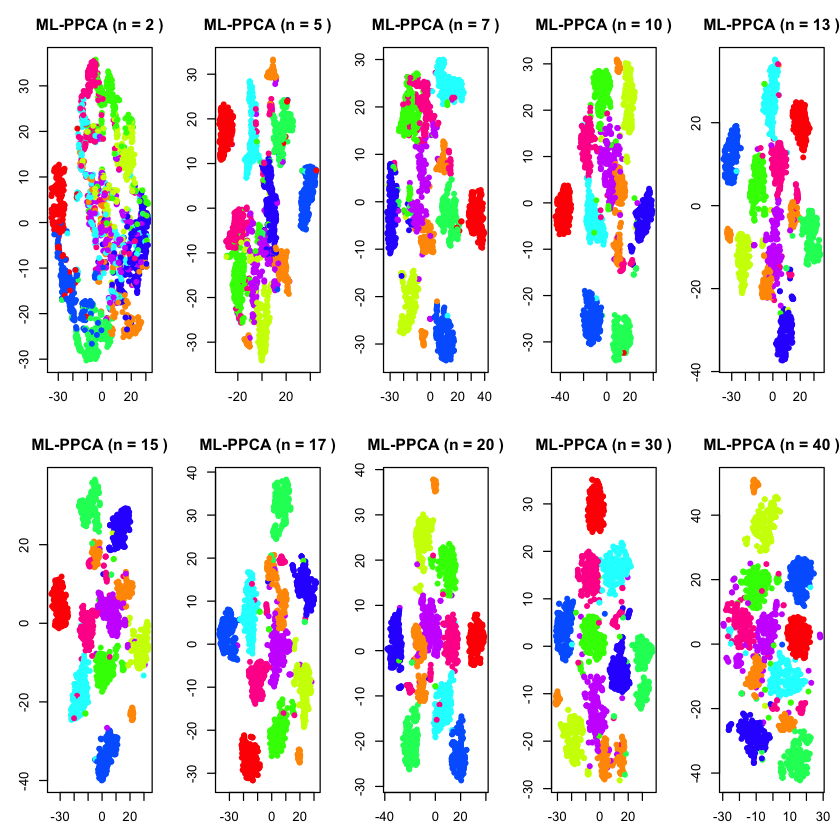

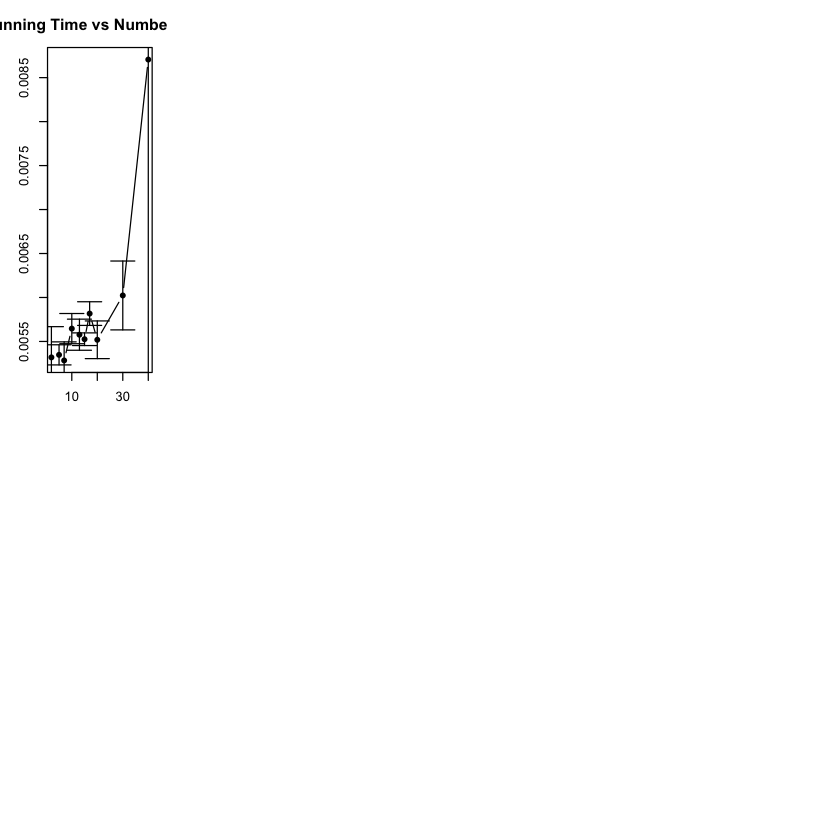

In [141]:
components_to_try <- c(2, 5, 7, 10, 13, 15, 17, 20, 30, 40)
compare_mlpca_components(X, y, components_list = components_to_try)

### PPCA-EM

In the following code, you just need to use your implement of EM PPCA to extract the latent embedding Z and record the log-likelihood values during iterations in function `run_ppca_em_once`

In [142]:
# Function to run PPCA-EM once and record time/convergence
run_ppca_em_once <- function(X, n_comp, n_iter, seed = NULL) {
  start_time <- Sys.time()
  
  # Initialize PPCA model
  ppca <- ProbabilisticPCA(X, n_comp, sigma2_init = 10, seed = seed)
  
  # Run EM iterations
  Q_history <- c(ppca$data_log_likelihood(ppca$compute_expectations()$E_zn,
                                         ppca$compute_expectations()$E_znzn))
  
  for (i in 1:n_iter) {
    Q <- ppca$EM_step()
    Q_history <- c(Q_history, Q)
    # Stop early if convergence is achieved
    if (i > 1 && abs(Q_history[length(Q_history)] - Q_history[length(Q_history)-1]) < 1e-3)
      break
  }
  
  # Get final projection
  Z <- t(ppca$project())  # Transpose to get (N x M)
  
  end_time <- Sys.time()
  time_taken <- as.numeric(difftime(end_time, start_time, units = "secs"))
  
  return(list(
    time_taken = time_taken,
    Z = Z,
    W = ppca$W,
    sigma2 = ppca$sigma2,
    Q_history = Q_history
  ))
}



In [143]:

# Compare PPCA-EM results with different components
compare_ppca_em_components <- function(X, y, components_list = c(2, 5, 10, 20), 
                                     n_runs = 3, n_iter = 30) {
  n_plots <- length(components_list)
  n_cols <- 5
  n_rows <- ceiling(n_plots / n_cols)
  
  # Set up plotting grid
  par(mfrow = c(n_rows, n_cols), mar = c(3, 3, 3, 1))
  
  running_times <- numeric(length(components_list))
  running_times_std <- numeric(length(components_list))
  convergence_iters <- numeric(length(components_list))
  convergence_iters_std <- numeric(length(components_list))
  
  for (idx in 1:length(components_list)) {
    n_comp <- components_list[idx]
    
    # Run multiple times and record metrics
    times <- numeric(n_runs)
    iters <- numeric(n_runs)
    for (run in 1:n_runs) {
      result <- run_ppca_em_once(X, n_comp, n_iter, seed = 42 + run)
      times[run] <- result$time_taken
      iters[run] <- length(result$Q_history) - 1
    }
    
    # Calculate statistics
    mean_time <- mean(times)
    std_time <- sd(times)
    mean_iters <- mean(iters)
    std_iters <- sd(iters)
    
    running_times[idx] <- mean_time
    running_times_std[idx] <- std_time
    convergence_iters[idx] <- mean_iters
    convergence_iters_std[idx] <- std_iters
    
    # Visualize with t-SNE
    ppca_result <- run_ppca_em_once(X, n_comp, n_iter)
    Z_2d <- Rtsne(ppca_result$Z)$Y
    
    # Plot
    plot(Z_2d, col = rainbow(10)[y + 1], pch = 16,
         main = paste("PPCA EM (n =", n_comp, ")"),
         xlab = "Component 1", ylab = "Component 2")
  }
  
  # Plot running times with error bars
  plot(components_list, running_times, type = "b", pch = 16,
       xlab = "Number of Components", ylab = "Running Time (s)",
       main = "PPCA EM Running Time vs Number of Components")
  arrows(components_list, running_times - running_times_std,
         components_list, running_times + running_times_std,
         angle = 90, code = 3, length = 0.1)
  
  # Display results
  print(paste("Running times for PPCA-EM components:", 
              paste(running_times, collapse = ", ")))
  print(paste("Average iterations for convergence:", 
              paste(convergence_iters, collapse = ", ")))
}

[1] "Running times for PPCA-EM components: 1.84044361114502, 2.2340137163798, 2.50204197565715, 2.99619833628337, 3.4184049765269, 3.82845099767049, 4.1942462126414, 4.73675545056661, 8.46898794174194, 13.3081785837809"
[1] "Average iterations for convergence: 46.6666666666667, 50, 50, 50, 50, 50, 50, 50, 50, 50"


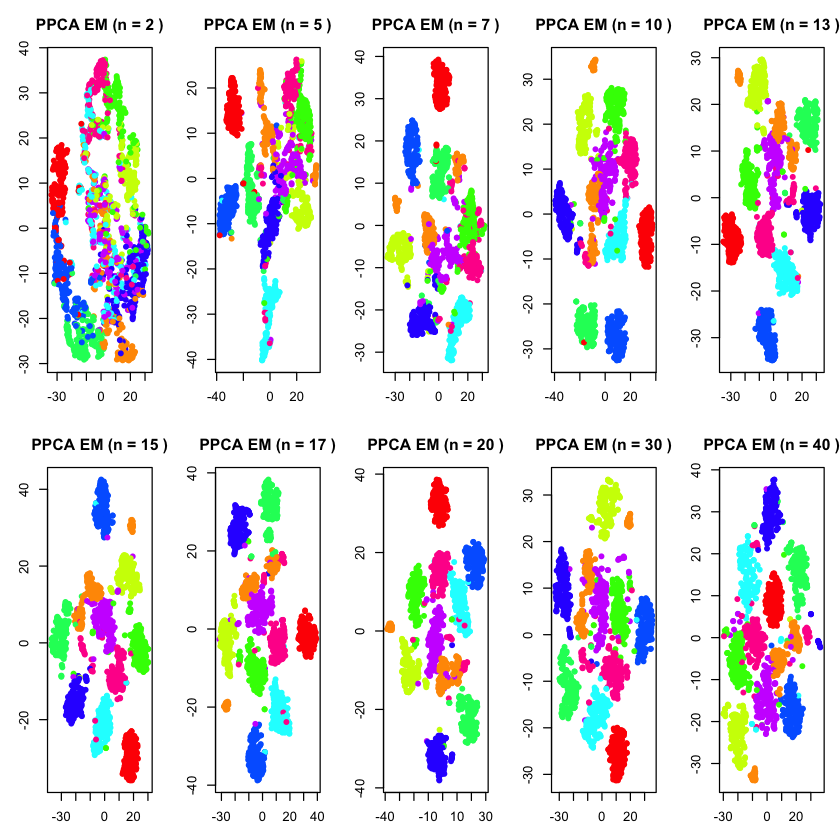

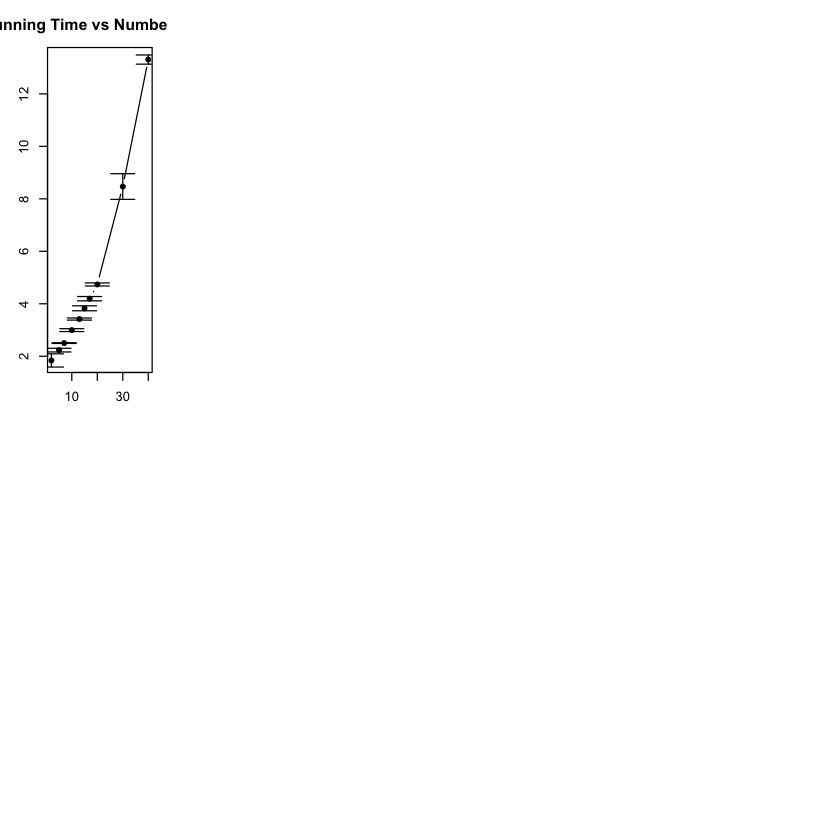

In [144]:
components_to_try <- c(2, 5, 7, 10, 13, 15, 17, 20, 30, 40)
compare_ppca_em_components(X, y, components_to_try, n_runs = 3, n_iter = 50)